In [1]:
from itertools import permutations, product

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

from sklearn.neural_network import MLPClassifier

from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

import numpy as np
from numpy import mean,std
from sklearn.model_selection import GridSearchCV

import pickle

from ctgan import CTGANSynthesizer

from os import path

import matplotlib.pyplot as plt

from warnings import simplefilter
from collections import OrderedDict
from sklearn import svm
if (os.path.abspath('').split('/')[-1] == 'project'):
    %cd utils
elif (os.path.abspath('').split('/')[-1] == 'train_and_vis'):
    %cd ../utils

import query_utils
import model_utils
import validation_utils
import data_utils

if (os.path.abspath('').split('/')[-1] == 'utils'):
    %cd ..


simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

/Users/benjaminli/Documents/coding/scires/project/utils
/Users/benjaminli/Documents/coding/scires/project


In [4]:
isZoonotic = df.loc[df['isZoonotic']==1][:1200]
isZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(isZoonotic)

posGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
posGanModel.fit(isZoonotic)

# check if current model is better than pickled model
posGanModel.save('models/curr_models/posGanModel.pkl')

          cctg      gtgt      acac      ccga      ttga      accg      ctca  \
0     0.297872  0.819149  0.446809  0.074468  0.265957  0.063830  0.106383   
1     0.297872  0.819149  0.446809  0.074468  0.265957  0.063830  0.106383   
2     0.297872  0.819149  0.446809  0.074468  0.265957  0.063830  0.106383   
3     0.367347  0.857143  0.469388  0.040816  0.295918  0.081633  0.081633   
4     0.483871  0.451613  0.580645  0.494624  0.311828  0.677419  0.129032   
...        ...       ...       ...       ...       ...       ...       ...   
1195  0.341772  0.265823  0.379747  0.101266  0.582278  0.126582  0.202532   
1196  0.368421  0.394737  0.513158  0.052632  0.500000  0.092105  0.236842   
1197  0.678571  0.797619  0.535714  0.071429  0.250000  0.166667  0.107143   
1198  0.549451  0.791209  0.527473  0.153846  0.296703  0.098901  0.087912   
1199  0.414634  0.292683  0.365854  0.060976  0.487805  0.158537  0.134146   

          tgtt      agcc      cgtt  ...      tggg      aata    

KeyboardInterrupt: 

In [50]:
notZoonotic = df.loc[df['isZoonotic']==0][:3000]
notZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(notZoonotic)

negGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
negGanModel.fit(notZoonotic)
negGanModel.save('models/curr_models/negGanModel.pkl')

          tggc      ttcc      tatg  ...      cttg      ctat      tctt
0     0.329787  0.297872  0.617021  ...  0.148936  0.393617  0.170213
1     0.377551  0.255102  0.744898  ...  0.153061  0.367347  0.112245
2     0.462366  0.279570  0.161290  ...  0.182796  0.193548  0.118280
3     0.455446  0.188119  0.475248  ...  0.188119  0.386139  0.138614
4     0.666667  0.333333  0.575758  ...  0.636364  0.515152  0.424242
...        ...       ...       ...  ...       ...       ...       ...
1195  0.404762  0.333333  0.571429  ...  0.261905  0.357143  0.202381
1196  0.417582  0.252747  0.637363  ...  0.208791  0.274725  0.153846
1197  0.341463  0.146341  0.329268  ...  0.207317  0.231707  0.231707
1198  0.192308  0.153846  0.461538  ...  0.166667  0.320513  0.230769
1199  0.226190  0.273810  0.428571  ...  0.166667  0.357143  0.285714

[1200 rows x 256 columns]
Epoch 1, Loss G:  1.8207,Loss D: -5.4888
Epoch 2, Loss G: -1.7336,Loss D: -0.0555
Epoch 3, Loss G: -1.9224,Loss D:  1.3800
Epoch 4, L

In [2]:
dataset1 = OrderedDict({})

dataset2 = OrderedDict({})

mergedDataset = OrderedDict({})


# load datasets with different kmer values
for kmer in range(3, 7):
    df_1_reg = pd.read_csv(f'data/dataset1/kmers-{str(kmer)}.csv')
    df_1_norm = pd.read_csv(f'data/dataset1/normalized-{str(kmer)}.csv')
    df_2_reg = pd.read_csv(f'data/dataset2/kmers-{str(kmer)}.csv')
    df_2_norm = pd.read_csv(f'data/dataset2/normalized-{str(kmer)}.csv')

    print("kmer: " + str(kmer))

    X_train, X_test, y_train, y_test = train_test_split(df_1_reg.loc[:, df_1_reg.columns != 'isZoonotic'], df_1_reg['isZoonotic'], test_size=0.2, random_state=1)
    # for col in df.columns:
    #     col != 'isZoonotic' and X_train[col].isnull().sum() != 0 and print(X_train[col].isnull().sum())
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    dataset1[f'regular-{kmer}'] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

    X_train, X_test, y_train, y_test = train_test_split(df_1_norm.loc[:, df_1_norm.columns != 'isZoonotic'], df_1_norm['isZoonotic'], test_size=0.2, random_state=1)
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    dataset1[f'normalized-{kmer}'] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

    X_train, X_test, y_train, y_test = train_test_split(df_2_reg.loc[:, df_2_reg.columns != 'isZoonotic'], df_2_reg['isZoonotic'], test_size=0.2, random_state=1)
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    dataset2[f'regular-{kmer}'] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

    X_train, X_test, y_train, y_test = train_test_split(df_2_norm.loc[:, df_2_norm.columns != 'isZoonotic'], df_2_norm['isZoonotic'], test_size=0.2, random_state=1)
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    dataset2[f'normalized-{kmer}'] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}


    # merge df_1 and df_2
    df_reg = df_1_reg.append(df_2_reg)
    df_norm = df_1_norm.append(df_2_norm)

    df_reg.reset_index(drop=True, inplace=True)
    df_norm.reset_index(drop=True, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(df_reg.loc[:, df_reg.columns != 'isZoonotic'], df_reg['isZoonotic'], test_size=0.2, random_state=1)
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    mergedDataset[f'regular-{kmer}'] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

    X_train, X_test, y_train, y_test = train_test_split(df_norm.loc[:, df_norm.columns != 'isZoonotic'], df_norm['isZoonotic'], test_size=0.2, random_state=1)
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    mergedDataset[f'normalized-{kmer}'] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

datasets = {"zhang": dataset1, "nardus": dataset2, "merged": mergedDataset}

kmer: 3
kmer: 4
kmer: 5
kmer: 6


In [ ]:
clf = svm.SVC(kernel='linear', probability=True)
model_utils.getOptimalModels(clf, datasets, kmer_range=[4, 6], onlyNormalized = True)

In [8]:
dsnames = ['zhang', 'nardus', 'merged']
kmers = [4, 6]
features = ['normalized', 'regular']

for kmer in range(kmers[0], kmers[1]+1):
    for dsname in dsnames:
        for feature in features:
            ds = datasets[dsname][f'{feature}-{kmer}']
            merged = datasets['merged'][f'{feature}-{kmer}']
            
            lrmodel = LogisticRegression(
                multi_class="multinomial", max_iter=1000,
                fit_intercept=False, tol=0.001, solver='saga', random_state=42)
            lrmodel.fit(ds['X_train'], ds['y_train'])
            acc = validation_utils.cross_validate(lrmodel, merged['X_test'], merged['y_test'])
            # predictions = lrmodel.predict(datasets['merged']['X_test'])
            # picklething = pickle.load(open('models/curr_models/lrmodel.pkl', 'rb'))
            # print(accuracy_score(merged['y_test'], predictions))
            # print(accuracy_score(merged['y_test'], picklething.predict(merged['X_test'])))
            model_utils.saveModel(lrmodel, "lrmodel", X_test, y_test, dir=f'models/curr_models/kmer{str(kmer)}')


# model_utils.saveModel(lrmodel, "lrmodel", X_test, y_test, dir='models/misc')

LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


Accuracy: 0.889 (0.017)
tn: 1829, fp: 53, fn: 157, tp: 197
LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.5s finished


Accuracy: 0.841 (0.004)
tn: 1881, fp: 1, fn: 354, tp: 0
LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished


Accuracy: 0.889 (0.017)
tn: 1766, fp: 116, fn: 250, tp: 104
LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.2s finished


Accuracy: 0.841 (0.004)
tn: 1836, fp: 46, fn: 320, tp: 34
LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished


Accuracy: 0.889 (0.017)
tn: 1825, fp: 57, fn: 159, tp: 195
LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.9s finished


Accuracy: 0.841 (0.004)
tn: 1879, fp: 3, fn: 354, tp: 0
LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.5s finished


Accuracy: 0.896 (0.016)
tn: 1829, fp: 53, fn: 121, tp: 233
LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   55.5s finished


Accuracy: 0.844 (0.010)
tn: 1880, fp: 2, fn: 354, tp: 0
LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


KeyboardInterrupt: 

In [4]:

merged = datasets['merged']['normalized-4']

ds = datasets['zhang'][f'normalized-4']
merged = datasets['merged'][f'normalized-4']

# print(len(ds['X_train'])+len(ds['X_test']))

lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(ds['X_train'], ds['y_train'])
acc = validation_utils.cross_validate(lrmodel, merged['X_test'], merged['y_test'])


ds = datasets['nardus'][f'normalized-4']
merged = datasets['merged'][f'normalized-4']

# print(len(ds['X_train'])+len(ds['X_test']))

lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(ds['X_train'], ds['y_train'])
acc = validation_utils.cross_validate(lrmodel, merged['X_test'], merged['y_test'])


ds = datasets['zhang'][f'normalized-4']
merged = datasets['merged'][f'normalized-4']

# print(len(ds['X_train'])+len(ds['X_test']))

lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(ds['X_train'], ds['y_train'])
acc = validation_utils.cross_validate(lrmodel, merged['X_test'], merged['y_test'])


ds = datasets['merged'][f'normalized-4']
merged = datasets['merged'][f'normalized-4']

# print(len(ds['X_train'])+len(ds['X_test']))

lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(ds['X_train'], ds['y_train'])
acc = validation_utils.cross_validate(lrmodel, merged['X_test'], merged['y_test'])

X_test, y_test = ds['X_test'], ds['y_test']
model_utils.saveModel(lrmodel, "lrmodel", X_test, y_test, dir="models/curr_models/kmer4")

LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished


Accuracy: 0.889 (0.017)
tn: 1829, fp: 53, fn: 157, tp: 197
LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished


Accuracy: 0.889 (0.017)
tn: 1766, fp: 116, fn: 250, tp: 104
LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished


Accuracy: 0.889 (0.017)
tn: 1829, fp: 53, fn: 157, tp: 197
LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.889 (0.017)
tn: 1825, fp: 57, fn: 159, tp: 195
LogisticRegression
LogisticRegression


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.889 (0.017)
tn: 1825, fp: 57, fn: 159, tp: 195
LogisticRegression
LogisticRegression
Accuracy: 0.889 (0.017)
tn: 1825, fp: 57, fn: 159, tp: 195
no update
curr 0.889 pickle 0.889
[1825   57  159  195]


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.9s finished


LogisticRegression(fit_intercept=False, max_iter=1000,
                   multi_class='multinomial', random_state=42, solver='saga',
                   tol=0.001)

In [4]:
kmer = 5
ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

knntest = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = 1), n_estimators = 10, n_jobs = 1)

knntest.fit(X_train, y_train)
# predictions = knntest.predict(X_test)
print(validation_utils.cross_validate(knntest, X_test, y_test))
# knn = KNeighborsClassifier(n_neighbors=5)
model_utils.saveModel(knntest, "knn", X_test, y_test, dir=f"models/curr_models/kmer{kmer}")

BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished


Accuracy: 0.819 (0.022)
tn: 1637, fp: 245, fn: 52, tp: 302
0.819
BalancedBaggingClassifier
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished


Accuracy: 0.819 (0.025)
tn: 1637, fp: 245, fn: 52, tp: 302
BalancedBaggingClassifier
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished


Accuracy: 0.821 (0.024)
tn: 1651, fp: 231, fn: 52, tp: 302
no update
curr 0.819 pickle 0.821
[1651  231   52  302]


BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighbors=1),
                          n_jobs=1)

In [53]:
merged = datasets['merged']['normalized-4']
X_train, y_train, X_test, y_test = merged['X_train'], merged['y_train'], merged['X_test'], merged['y_test']

predictions = knntest.predict(X_test)
picklething = pickle.load(open('models/curr_models/knn.pkl', 'rb'))

print(accuracy_score(y_test, predictions), accuracy_score(y_test, picklething.predict(X_test)))
# saveModel(knntest, "knn", X_test, y_test)

0.8193202146690519


In [7]:
kmer = 4
ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"))

randforest.fit(X_train, y_train)

# knn = KNeighborsClassifier(n_neighbors=5)
model_utils.saveModel(randforest, "randforest", X_test, y_test, dir=f"models/curr_models/kmer{kmer}")

BalancedBaggingClassifier
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.873 (0.023)
tn: 1749, fp: 133, fn: 75, tp: 279
BalancedBaggingClassifier
BalancedBaggingClassifier
Accuracy: 0.866 (0.024)
tn: 1743, fp: 139, fn: 82, tp: 272
update!
[1743  139   82  272]
curr 0.873 pickle 0.866


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'))

In [22]:
probability_predictions = randforest.predict_proba(X_test)
preds = randforest.predict(X_test)
print(accuracy_score(y_test, preds))


0.9294803817603393


In [38]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3
}


# careful with WARM START - only works after a lot of iterations
for learning_rate in lr_list:
    gradBoost = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, max_features=parameters['max_features'], 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample']
    )

    parameters['learning_rate']=learning_rate
    gradBoost.fit(X_train, y_train)

    cols_when_model_builds = gradBoost.feature_names_in_
    X_test=X_test[cols_when_model_builds]
    
    testingAcc = accuracy_score(y_test, gradBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, gradBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(gradBoost, "gradBoost", X_test, y_test, parameters, gradBoost=True, dir="models/synthetic_data_testing")

Learning rate:  0.05
Accuracy score (validation): 0.957
no update
curr 0.9565217391304348 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.075
Accuracy score (validation): 0.958
no update
curr 0.9581124072110286 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.1
Accuracy score (validation): 0.956
no update
curr 0.9559915164369035 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.15
Accuracy score (validation): 0.960
no update
curr 0.9602332979851538 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.2
Accuracy score (validation): 0.963
no update
curr 0.9628844114528102 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.25
Accuracy score (validation): 0.958
no update
curr 0.9575821845174973 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.3
Accuracy score (validation): 0.958
no update
curr 0.9575821845174973 pickle 0.9883351007423118
[1629    5   17  235]
Learning rate:  0.35
Accuracy score 

In [39]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "subsample":0.8,
    'lambda': 0.5, # regularization?
    'alpha': 0.5
}



for learning_rate in lr_list:
    xgBoost = XGBClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    subsample=parameters['subsample'], 
    )

    parameters['learning_rate']=learning_rate
    xgBoost.fit(X_train, y_train)

    # ALWAYS reset feature names
    cols_when_model_builds = xgBoost.get_booster().feature_names
    X_test=X_test[cols_when_model_builds]

    testingAcc = accuracy_score(y_test, xgBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, xgBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(xgBoost, "xgBoost", X_test, y_test, parameters, xgBoost=True, dir="models/synthetic_data_testing")

Learning rate:  0.05
Accuracy score (validation): 0.960
no update
curr 0.9602332979851538 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.075
Accuracy score (validation): 0.962
no update
curr 0.9623541887592789 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.1
Accuracy score (validation): 0.962
no update
curr 0.9618239660657476 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.15
Accuracy score (validation): 0.963
no update
curr 0.9634146341463414 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.2
Accuracy score (validation): 0.966
no update
curr 0.9655355249204666 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.25
Accuracy score (validation): 0.963
no update
curr 0.9634146341463414 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.3
Accuracy score (validation): 0.961
no update
curr 0.9612937433722163 pickle 0.9904559915164369
[1632    2   16  236]
Learning rate:  0.35
Accuracy score 

In [ ]:
"""
{'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3}
"""
kmer = 4
ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

# knn = KNeighborsClassifier(n_neighbors=5)
parameters={
   'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3
}

param_test1 = {'n_estimators':range(100,140,10), 'learning_rate':[0.1,0.15,0.2], 'subsample':[0.8,0.85,0.9], 'max_depth':range(6,9,1), 'min_samples_split':range(10,40,10), 'max_features':range(2, 5)}

gradBoost = GridSearchCV(estimator = GradientBoostingClassifier(
    n_estimators=parameters['n_estimators'], max_features=parameters['max_features'], random_state=parameters['random_state']), 
param_grid = param_test1, scoring='roc_auc',n_jobs=-1, cv=5, verbose=10)

# parameters['learning_rate']=learning_rate
gradBoost.fit(X_train, y_train)

{'learning_rate': 0.15, 'max_depth': 8, 'max_features': 3, 'min_samples_split': 30, 'n_estimators': 130, 'subsample': 0.8}
GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.918 (0.015)
tn: 1864, fp: 18, fn: 113, tp: 241
0.918
GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.1s finished


Accuracy: 0.920 (0.014)
tn: 1877, fp: 5, fn: 33, tp: 321
0.92
GradientBoostingClassifier
gradboost
precision recall: 0.9836942204649143
roc: 0.9945394069297598


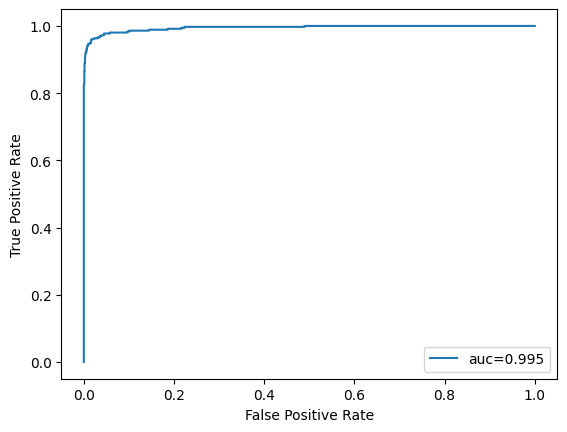

[0.00548521 0.00180334 0.00079118 ... 0.00184853 0.00543782 0.00500435]
(array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0010627 , 0.0010627 , 0.00159405, 0.00159405,
       0.00265675, 0.00265675, 0.0031881 , 0.0031881 , 0.00371945,
       0.0042508 , 0.0042508 , 0.0053135 , 0.0053135 , 0.00584485,
       0.00584485, 0.0063762 , 0.0063762 , 0.00690755, 0.00690755,
       0.00797024, 0.00797024, 0.00903294, 0.00903294, 0.00956429,
       0.00956429, 0.01328374, 0.01328374, 0.01434644, 0.01540914,
       0.01594049, 0.01594049, 0.01647184, 0.01647184, 0.02284803,
       0.02284803, 0.03081828, 0.03081828, 0.03241233, 0.03347503,
       0.03560043, 0.03560043, 0.03772582, 0.03772582, 0.03931987,
       0.04038257, 0.04463337, 0.04463337, 0.04994687, 0.05100956,
       0.05366631, 0.05472901, 0.05738576, 0.05738576, 0.09564293,
       0.09564293, 0.09989373, 0.10095643, 0.10095643, 0

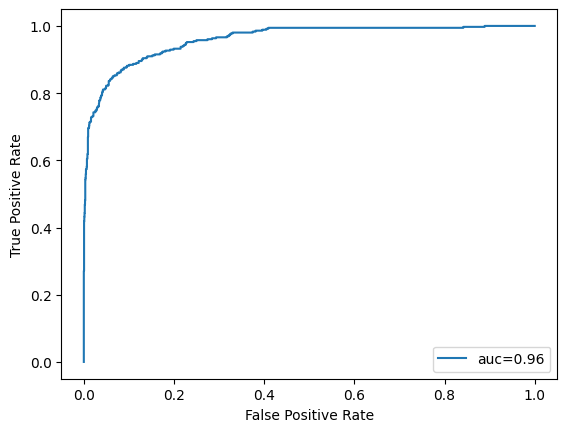

[0.01436602 0.00302472 0.00117355 ... 0.00078883 0.02261897 0.0195416 ]
(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.31349628e-04, 5.31349628e-04, 5.31349628e-04,
       5.31349628e-04, 1.06269926e-03, 1.06269926e-03, 1.59404888e-03,
       1.59404888e-03, 2.12539851e-03, 2.12539851e-03, 2.65674814e-03,
       2.65674814e-03, 3.18809777e-03, 3.18809777e-03, 3.71944740e-03,
       3.71944740e-03, 4.25079702e-03, 4.25079702e-03, 4.78214665e-03,
       4.78214665e-03, 6.37619554e-03, 6.37619554e-03, 6.90754516e-03,
       6.90754516e-03, 7.97024442e-03, 7.97024442e-03, 9.03294368e-03,
       9.03294368e-03, 9.03294368e-03, 9.03294368e-03, 9.03294368e-03,
       9.03294368e-03, 9.56429330e-03, 9.56429330e-03, 9.56429330e-03,
       9.56429330e-03, 9.56429330e-03, 1.06269926e-02, 1.06269926e-02,
       1.16896918e-02, 1.16896918e-02, 1.22210414e-02, 1.22210414e-02,
       1.32837407e-02, 1.32837407e-02, 1.43464400e-02, 1.54091392e-02,
    

In [10]:
"""
{'learning_rate': 0.15, 'max_depth': 8, 'max_features': 3, 'min_samples_split': 30, 'n_estimators': 130, 'subsample': 0.8}
"""
print(gradBoost.best_params_)
print(validation_utils.cross_validate(gradBoost.best_estimator_, X_test, y_test))
pi = pickle.load(open('models/curr_models/nardus_gridsearch.pkl', 'rb'))
print(validation_utils.cross_validate(pi.best_estimator_, X_test, y_test))
print(validation_utils.draw_roc_curve(pi.best_estimator_, X_test, y_test))
print(validation_utils.draw_roc_curve(gradBoost.best_estimator_, X_test, y_test))

In [14]:
pickle.dump(gradBoost, open('models/test/nardus_gridsearch.pkl', 'wb'))

X_test = data_utils.transform_data(gradBoost.best_estimator_, X_test)
print(validation_utils.cross_validate(gradBoost.best_estimator_, X_test, y_test))
print(pi.best_params_)
print(validation_utils.cross_validate(pi.best_estimator_, X_test, y_test))


GradientBoostingClassifier
gradboost
GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.918 (0.015)
tn: 1864, fp: 18, fn: 113, tp: 241
0.918
{'learning_rate': 0.1, 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 140, 'subsample': 0.9}
GradientBoostingClassifier
gradboost
Accuracy: 0.920 (0.014)
tn: 1877, fp: 5, fn: 33, tp: 321
0.92


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished
